In [46]:
import pyspark.sql.functions as sql
import pyspark.sql.types as types
idb_df_version = "20161119"
size="-100k"

In [47]:
idb_tf_df = sqlContext.read.parquet("/guoda/data/idigbio-{0}-tf{1}.parquet".format(idb_df_version, size))
idb_tf_df.count()

232306

In [48]:
idb_df = sqlContext.read.parquet("/guoda/data/idigbio-{0}{1}.parquet".format(idb_df_version, size))
idb_df.count()

100000

In [49]:
idb_df_ids = (idb_df
              .select(idb_df["uuid"].alias("idb_uuid"),
                      idb_df["catalognumber"].alias("idb_catalognumber"))
              )

In [50]:
idb_df_notes = (idb_df
               .select(idb_df["uuid"].alias("note_uuid"),
                       sql.concat_ws(" ", idb_df["data.dwc:occurrenceRemarks"],
                          idb_df["data.dwc:eventRemarks"],
                          idb_df["data.dwc:fieldNotes"]
                          )
                          .alias("note")
                      )
               )
idb_df_notes.head()

Row(note_uuid='b73cb619-3129-4d58-ad05-ed74d15ada4c', note='')

In [51]:
joined = (idb_df_ids        
          .join(idb_tf_df, on=idb_df_ids["idb_catalognumber"]==idb_tf_df["token"])
          .join(idb_df_notes, on=sql.column("uuid")==idb_df_notes["note_uuid"])
          .withColumn("catalognumber_len", sql.length(sql.column("idb_catalognumber")))
         )

joined.count()

6839

In [52]:
joined.head()

Row(idb_uuid='b73f7532-78dd-4aae-a874-707ffd8b5622', idb_catalognumber='4891', uuid='b819d2c3-636b-4011-8070-507d31e926b6', token='4891', count=1, note_uuid='b819d2c3-636b-4011-8070-507d31e926b6', note="[ Eugamasus lyriformis | 4891 | PN | inner bark | lob. 16' | cut 5.14.65 emad. | coll 6.14.65 gone | D. Frontalis only | Elizabeth, La. ][ AL12910 | OSAL04838 | live | J. Moser - Berlese's ]", catalognumber_len=4)

In [53]:
length_pd = (joined
               .groupBy(joined["catalognumber_len"])
               .count()
               ).toPandas()
length_pd.head(2)

,catalognumber_len,count
0,1,2503
1,6,33


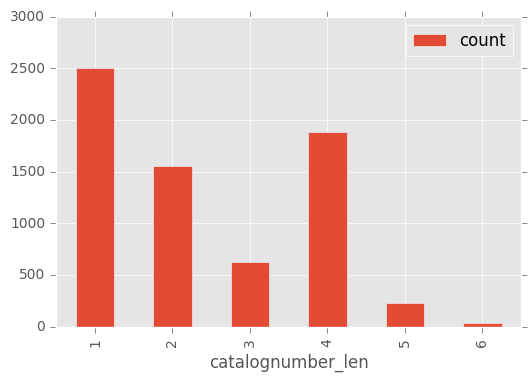

In [54]:
import matplotlib
import matplotlib.pyplot as plt
matplotlib.style.use('ggplot')

plt.figure();
(length_pd
 .sort_values(by="catalognumber_len")
 .plot(x="catalognumber_len", y="count", kind="bar")
)